In [1]:
import pandas as pd
import numpy as np

from turtle import color
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib_inline
import statsmodels as sm


from sklearn.model_selection import train_test_split as skl

from sklearn.ensemble import BaggingRegressor
#### Bagging con KNN como estimador base
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
import sklearn
# CONTEXTO EN CLASIFICACIÓN
sklearn.ensemble.RandomForestRegressor
sklearn.ensemble.RandomForestClassifier
# importar librerías
from sklearn import tree

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn import metrics

from sklearn.preprocessing import PolynomialFeatures, StandardScaler ### preprocesar los datos
from sklearn.model_selection import cross_val_score #### 
from sklearn.model_selection import GridSearchCV #### Validación cruzada
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn import model_selection
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, make_scorer
from sklearn.metrics import make_scorer, mean_squared_error
#from sklearn.tree import DecisionTreeRegressor


### 1. Carga base de datos

In [2]:
kernel='C:/Users/miavila/Documents/U/PROYECTO P/basef/'
df=pd.read_excel(kernel + '4.total agru_hour.xlsx')
df=pd.DataFrame(df,columns=['FechaT', 'Fecha', 'Operación_N', 'sumRecibidas', 'festivo','festividades',
       'MesN', 'Dia_MesN', 'Dia_SemN', 'Hora24'])


df['Operación_N'].replace(['Pensilvania'],['U_Persona_Natural'],inplace=True)   

agru = df.groupby(['FechaT', 'Fecha', 'Operación_N', 'festivo','festividades',
       'MesN', 'Dia_MesN', 'Dia_SemN', 'Hora24'],dropna=False,as_index=False)['sumRecibidas'].sum()  

df=pd.DataFrame(agru,columns=['FechaT', 'Fecha', 'Operación_N', 'sumRecibidas', 'festivo','festividades',
       'MesN', 'Dia_MesN', 'Dia_SemN', 'Hora24'])
UPN=df[df['Operación_N']=='U_Persona_Natural']

UPN=UPN.sort_values(by='FechaT') #ascending=False 
UPN.index = range(UPN.shape[0])

In [3]:
df.Operación_N.unique()
from os import replace
#P=df[df['Operación_N']=='Pensilvania']
BIO=df[df['Operación_N']=='Biometria']
CON=df[df['Operación_N']=='Conservacion']
EP=df[df['Operación_N']=='Ejecutivo Premium']
EB=df[df['Operación_N']=='Especializados Bloqueos']
EBF=df[df['Operación_N']=='Especializados Bloqueos F']
ME=df[df['Operación_N']=='Moneda Extranjera - Home']
OR=df[df['Operación_N']=='Orquestador']
PJH=df[df['Operación_N']=='Persona Juridica - Home']
CAV=df[df['Operación_N']=='CAV']
VIP=df[df['Operación_N']=='VIP PJ']

In [4]:
UPN=pd.DataFrame(UPN,columns=( 'FechaT','Hora24', 'sumRecibidas',
       'festivo', 'festividades','MesN', 'Dia_MesN', 'Dia_SemN'))

In [5]:
UPN

,FechaT,Hora24,sumRecibidas,festivo,festividades,MesN,Dia_MesN,Dia_SemN
0,2022-01-01 00:00:00,0,0,1,0,1,1,6
1,2022-01-01 01:00:00,1,0,1,0,1,1,6
2,2022-01-01 02:00:00,2,0,1,0,1,1,6
3,2022-01-01 03:00:00,3,0,1,0,1,1,6
4,2022-01-01 04:00:00,4,0,1,0,1,1,6
...,...,...,...,...,...,...,...,...
5827,2022-08-31 19:00:00,19,890,0,0,8,31,3
5828,2022-08-31 20:00:00,20,581,0,0,8,31,3
5829,2022-08-31 21:00:00,21,357,0,0,8,31,3
5830,2022-08-31 22:00:00,22,216,0,0,8,31,3


In [7]:
UPN2 = UPN.set_index('FechaT')

### 2. Separación datos train-val-test

In [8]:
fin_train = '2022-07-31 23:00:00'
fin_validacion = '2022-08-31 23:00:00'
datos_train = UPN2.loc[: fin_train, :]
datos_test   = UPN2.loc[fin_train:fin_validacion, :]


print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
datos_test=datos_test.drop(['2022-07-31 23:00:00'])
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")


Fechas train      : 2022-01-01 00:00:00 --- 2022-07-31 23:00:00  (n=5088)
Fechas test  : 2022-08-01 00:00:00 --- 2022-08-31 23:00:00  (n=744)


In [57]:
X_train, X_test, y_train, y_test = datos_train.drop(columns = ['sumRecibidas']),datos_test.drop(columns=['sumRecibidas']) ,datos_train.sumRecibidas    ,datos_test.sumRecibidas

# GRILLA DE VALIDACIÓN

#### 4. Grid Search - busqueda optima de combinación de hiperparametros

### Definir Grilla de validación


In [13]:
RFmodel =sklearn.ensemble.RandomForestRegressor( random_state = 12345) # semilla para replicar los resultados
RFmodel

RandomForestRegressor(random_state=12345)

parameters = [ {#'ccp_alpha': np.linspace(0.0,1, 10),
            'max_depth':np.arange(1, 20),"max_features":np.arange(1,5),
             'min_samples_split': np.linspace(0.001, 0.5, 300),
             
             'n_estimators': [100],
            }]

* Definir medida de desempeño
acc_scorer = make_scorer(mean_squared_error, greater_is_better=False)

* Grilla                                    Vuelva a ajustar un estimador     /  verbose / predispach
*                                       utilizando los mejores parámetros / numero de mensajes / job 
paralelo                              
grid_obj = GridSearchCV(estimator = RFmodel, param_grid = parameters,
 scoring=acc_scorer, cv = 10, n_jobs=-1,refit=True,verbose=3,
 pre_dispatch=5, return_train_score = True)

In [14]:
#grid_obj = grid_obj.fit(X_train, y_train)

In [15]:
#grid_obj.get_params(deep=True)

### 4.1 Seleción de la mejor combinación de parametros
###  dependiendo del acc_scorrer

In [16]:
# Set the clf to the best combination of parameters
#tree_clf_best = grid_obj.best_estimator_
#tree_pred = tree_clf_best.predict(X_train)

In [17]:
#tree_clf_best

### 5. Metricas de desempeño 
### Validando el desempeño del modelo 

In [18]:
#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, tree_pred))
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, tree_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, tree_pred)))

In [19]:
#resulta = pd.DataFrame(grid_obj.cv_results_)
#resulta

### 6. Importancia del variables
### tener en cuenta que son objetivas

In [20]:
## Importancia de las variables, # qeu tan importante es la variables con capacidad para reememplazar varibales
#importan = tree_clf_best.feature_importances_
#importan = dict(zip(UPN.columns.tolist(), importan))
#importan = pd.DataFrame(importan,index=[0])

In [21]:
#import matplotlib.pyplot as plt
#importan.iloc[0].plot(kind='bar')
#aportación de las variables

### 7. GRAFICA Real vs Pronostico


In [22]:
#y_predd = pd.DataFrame(tree_pred)

In [23]:
#fig, ax = plt.subplots(figsize=(12,8))
#y_test.plot(ax=ax, label="Valores Reales")
#y_predd.plot(ax=ax, label="RandomForest") #,color = "orange"


#ax.legend()
#fig.show()

___

# II. MODELO ENTRENADO


In [9]:
X_train, X_test, y_train, y_test = datos_train.drop(columns = ['sumRecibidas','MesN']),datos_test.drop(columns=['sumRecibidas','MesN']) ,datos_train.sumRecibidas    ,datos_test.sumRecibidas

In [30]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
  
 # create regressor object
regressor = RandomForestRegressor(n_estimators =30,max_features=5,max_depth=30,min_samples_split=0.001, random_state = 123456)

# fit the regressor with x and y data
modelRF=regressor.fit(X_train, y_train) 
modelRF

RandomForestRegressor(max_depth=30, max_features=5, min_samples_split=0.001,
                      n_estimators=30, random_state=123456)

### Guardar y exportar el modelo

In [15]:
from joblib import dump
#EXPORTAR EL MODELO
#
#dump(modelRF, 'regression.joblib') 

#IMPORTAR EL MODELO
from joblib import load
regression_model = load('regression.joblib')


modelRF=regression_model.fit(X_train, y_train)

In [21]:
modelRF.feature_importances_

array([0.74319264, 0.05523721, 0.00112491, 0.02045197, 0.17999327])

### II. PREDICIÓN

In [28]:
tree_pred =modelRF.predict(X_test)

### II. Metricas de desempeño 
### Validando el desempeño del modelo 

In [31]:
from sklearn.metrics import  mean_absolute_percentage_error, mean_squared_error,mean_absolute_error
print('Mean Absolute Error:    ', metrics.mean_absolute_error(y_test, tree_pred))
print('Mean Squared Error:     ', metrics.mean_squared_error(y_test, tree_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, tree_pred)))
print('-------------------------------------------')
print('cantidad total real:       ',y_test.sum() ) 
print('cantidad total pronostico: ',int(tree_pred.sum()))
print('diferencia:                ',int(y_test.sum()-tree_pred.sum()) )
print(str(round(2415.0613*100/tree_pred.sum(),2)) +' %')

Mean Absolute Error:     65.77397992209653
Mean Squared Error:      18223.89873265267
Root Mean Squared Error: 134.99592117042897
-------------------------------------------
cantidad total real:        565621
cantidad total pronostico:  557572
diferencia:                 8048
0.43 %


In [13]:
565621/31

18245.83870967742

### II. Diferencia del total de llamadas por mes}
* 6529

In [ ]:
## Importancia de las variables, # qeu tan importante es la variables con capacidad para reememplazar varibales
importan = modelRF.feature_importances_
importan = dict(zip(X_train.columns.tolist(), importan))
importan = pd.DataFrame(importan,index=[0])

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,5))
importan.iloc[0].plot(kind='bar')
#aportación de las variables
plt.title("IMPORTANCIA DE LAS VARIABLES",fontsize = 15)

In [25]:
y_predd = pd.DataFrame(np.round(tree_pred))
y_predd.index=y_test.index
y_predd.rename(columns={0:'Predicción'},inplace=True)
y_predd

,Predicción
FechaT,
2022-08-01 00:00:00,18.0
2022-08-01 01:00:00,9.0
2022-08-01 02:00:00,5.0
2022-08-01 03:00:00,6.0
2022-08-01 04:00:00,10.0
...,...
2022-08-31 19:00:00,879.0
2022-08-31 20:00:00,630.0
2022-08-31 21:00:00,451.0


C:\Users\miavila\AppData\Local\Temp\ipykernel_17928\428401559.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


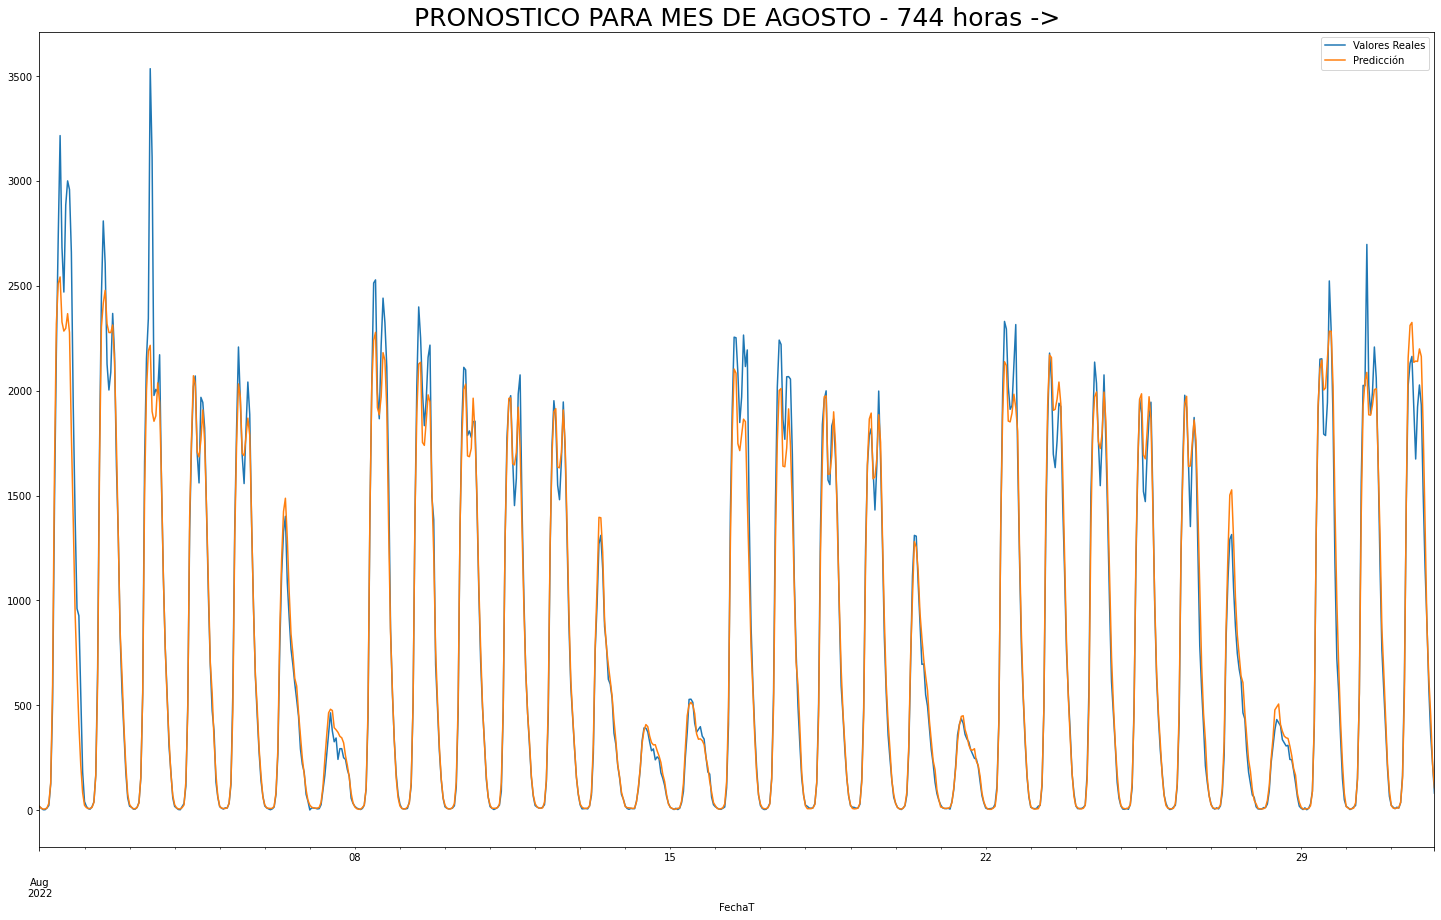

In [26]:
fig, ax = plt.subplots(figsize=(25,15))
y_test.plot(ax=ax, label="Valores Reales")
y_predd.plot(ax=ax) #,color = "orange"
plt.title("PRONOSTICO PARA MES DE AGOSTO - 744 horas ->",fontsize = 25)

ax.legend()
fig.show()

# grafica del arbol

fn=X_train.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,30), dpi=900)
tree.plot_tree(modelRF.estimators_[0],
               feature_names = fn, 
               #lass_names=cn,
               filled = True);
fig.savefig('rf_individualtreefinal n_estimators =20,max_features=4,max_depth=15,min_samples_split=0.001.png')

* 3 arboles visualizción
 This may not the best way to view each estimator as it is small
fn=X_train.columns
#cn=nmp.target_names
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (20,10), dpi=900)
for index in range(0, 3):
    tree.plot_tree(modelRF.estimators_[index],
                   feature_names = fn, 
                   #class_names=cn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

# ZX
### MODELO PARA INCIDENTES

In [28]:
INC=pd.read_excel('C:/Users/miavila/Documents/U/PROYECTO P/variables exogenas/INCIDENTES.xlsx',sheet_name='INCIDENTES ONLY FECHA')
INC=INC.set_index('Fecha')

INC=pd.DataFrame(INC,columns=(  'INC_HIT', 'festivo', 'festividades', 'Dia_MesN',
       'Dia_SemN','MesN'))
INC

,INC_HIT,festivo,festividades,Dia_MesN,Dia_SemN,MesN
Fecha,,,,,,
2022-01-01,0,1,0,1,6,1
2022-01-02,0,0,0,2,7,1
2022-01-03,340,0,0,3,1,1
2022-01-04,703,0,0,4,2,1
2022-01-05,0,0,0,5,3,1
...,...,...,...,...,...,...
2022-08-27,0,0,0,27,6,8
2022-08-28,0,0,0,28,7,8
2022-08-29,873,0,0,29,1,8


In [29]:
# Separación datos train-val-test

fin_train = '2022-07-31'
fin_validacion = '2022-08-31'
datos_train = INC.loc[: fin_train, :]
datos_test   = INC.loc[fin_train:fin_validacion, :]


print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
datos_test=datos_test.drop(['2022-07-31'])
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2022-01-01 00:00:00 --- 2022-07-31 00:00:00  (n=212)
Fechas test  : 2022-08-01 00:00:00 --- 2022-08-31 00:00:00  (n=31)


In [30]:
X_train

,Hora24,festivo,festividades,Dia_MesN,Dia_SemN
FechaT,,,,,
2022-01-01 00:00:00,0,1,0,1,6
2022-01-01 01:00:00,1,1,0,1,6
2022-01-01 02:00:00,2,1,0,1,6
2022-01-01 03:00:00,3,1,0,1,6
2022-01-01 04:00:00,4,1,0,1,6
...,...,...,...,...,...
2022-07-31 19:00:00,19,0,0,31,7
2022-07-31 20:00:00,20,0,0,31,7
2022-07-31 21:00:00,21,0,0,31,7


In [31]:
X_train, X_test, y_train, y_test = datos_train.drop(columns = ['INC_HIT']),datos_test.drop(columns=['INC_HIT']) ,datos_train.INC_HIT    ,datos_test.INC_HIT

In [32]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
  
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 70,max_features=5,max_depth=8,min_samples_split=0.01, random_state = 123456)

# fit the regressor with x and y data
regressor.fit(X_train, y_train) 

RandomForestRegressor(max_depth=8, max_features=5, min_samples_split=0.01,
                      n_estimators=70, random_state=123456)

In [33]:
tree_pred =regressor.predict(X_test)

In [34]:
from sklearn.metrics import  mean_absolute_percentage_error, mean_squared_error,mean_absolute_error
print('Mean Absolute Error:    ', metrics.mean_absolute_error(y_test, tree_pred))
print('Mean Squared Error:     ', metrics.mean_squared_error(y_test, tree_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, tree_pred)))
print('-------------------------------------------')
print('cantidad total real:       ',y_test.sum() )
print('cantidad total pronostico: ',int(tree_pred.sum()))
print('diferencia:                ',int(y_test.sum()-tree_pred.sum()) )


Mean Absolute Error:     114.33348599111295
Mean Squared Error:      34420.41924541617
Root Mean Squared Error: 185.52740834015918
-------------------------------------------
cantidad total real:        4315
cantidad total pronostico:  4654
diferencia:                 -339


In [35]:
y_predd = pd.DataFrame(np.round(tree_pred))
y_predd.index=y_test.index
y_predd.rename(columns={0:'Predicción'},inplace=True)
y_predd

,Predicción
Fecha,
2022-08-01,621.0
2022-08-02,532.0
2022-08-03,475.0
2022-08-04,342.0
2022-08-05,329.0
2022-08-06,88.0
2022-08-07,34.0
2022-08-08,131.0
2022-08-09,67.0


C:\Users\miavila\AppData\Local\Temp\ipykernel_17928\839624423.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


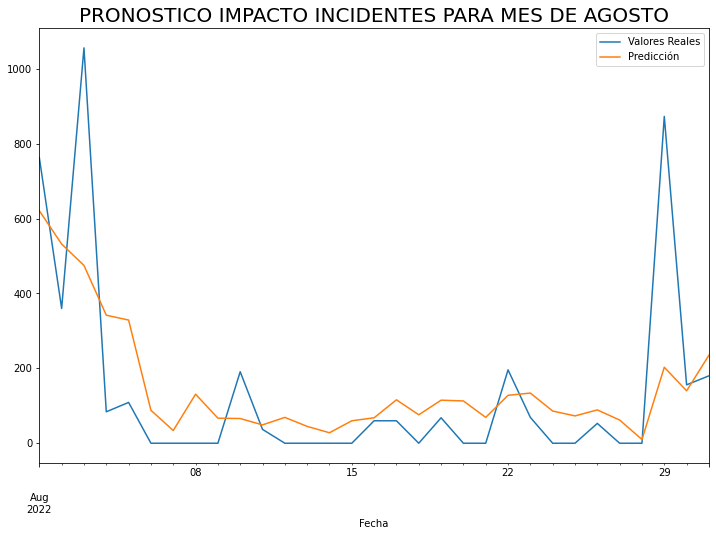

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
y_test.plot(ax=ax, label="Valores Reales")
y_predd.plot(ax=ax, label="RandomForest") #,color = "orange"
plt.title("PRONOSTICO IMPACTO INCIDENTES PARA MES DE AGOSTO",fontsize = 20)

ax.legend()
fig.show()

# 3 MODELO CONCATENANDO RESULTADOS INC_HIT


In [ ]:
INC=pd.read_excel('C:/Users/miavila/Documents/U/PROYECTO P/variables exogenas/INCIDENTES.xlsx',sheet_name='INCIDENTES ONLY FECHA')
INC=pd.DataFrame(INC,columns=(  'Fecha','INC_HIT'))

UPN=pd.DataFrame(UPN,columns=( 'Fecha','FechaT', 'Hora24', 'Operación_N', 'sumRecibidas',
       'festivo', 'MesN', 'Dia_MesN', 'Dia_SemN'))
UPN['Fecha'] = UPN['FechaT'].dt.date.astype(str)
UPN['Fecha'] =pd.to_datetime(UPN['Fecha'])
UPN

In [ ]:
#cruzar las bases
HIT_PN = pd.merge(UPN,INC,on='Fecha')
HIT_PN=HIT_PN.set_index('FechaT')
HIT_PN

In [39]:
# Separación datos train-val-test

fin_train = '2022-07-31 23:00:00'
fin_validacion = '2022-08-31 23:00:00'
datos_train = HIT_PN.loc[: fin_train, :]
datos_test   =HIT_PN.loc[fin_train:fin_validacion, :]


print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
datos_test=datos_test.drop(['2022-07-31 23:00:00'])
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")


Fechas train      : 2022-01-01 00:00:00 --- 2022-07-31 23:00:00  (n=5088)
Fechas test  : 2022-08-01 00:00:00 --- 2022-08-31 23:00:00  (n=744)


In [40]:
X_train, X_test = datos_train.drop(columns = ['sumRecibidas','Operación_N']) , datos_test.drop(columns=['sumRecibidas','Operación_N']) 
y_train, y_test = datos_train.sumRecibidas , datos_test.sumRecibidas

In [41]:
X_train

,Fecha,Hora24,festivo,MesN,Dia_MesN,Dia_SemN,INC_HIT
FechaT,,,,,,,
2022-01-01 00:00:00,2022-01-01,0,1,1,1,6,0
2022-01-01 01:00:00,2022-01-01,1,1,1,1,6,0
2022-01-01 02:00:00,2022-01-01,2,1,1,1,6,0
2022-01-01 03:00:00,2022-01-01,3,1,1,1,6,0
2022-01-01 04:00:00,2022-01-01,4,1,1,1,6,0
...,...,...,...,...,...,...,...
2022-07-31 19:00:00,2022-07-31,19,0,7,31,7,0
2022-07-31 20:00:00,2022-07-31,20,0,7,31,7,0
2022-07-31 21:00:00,2022-07-31,21,0,7,31,7,0


### INDEXAR PRONOSTICO DE INCIDENTES HIT

In [42]:
predINC_HIT=pd.read_excel('C:/Users/miavila/Documents/U/PROYECTO P/PRONOSTICO INCIDENTES/pronostico agosto HIT.xlsx')
predINC_HIT.rename(columns={0:'Predicción_INC_HIT'},inplace=True)
predINC_HIT.tail()

,Fecha,Predicción
26,2022-08-27,0
27,2022-08-28,0
28,2022-08-29,600
29,2022-08-30,175
30,2022-08-31,236


In [43]:
#reset el index
X_test.reset_index(level=0,inplace=True)
#cruzar las bases
X_testP_I = pd.merge(X_test,predINC_HIT,on='Fecha')
#elimina la columna de impacto real de agosto
X_testP_I.drop(columns=['INC_HIT'],inplace=True)
# reemplaza la columna de impacto por el pronostico
X_testP_I.rename(columns={'Predicción_INC_HIT':'INC_HIT'},inplace=True)
X_testP_I

,FechaT,Fecha,Hora24,festivo,MesN,Dia_MesN,Dia_SemN,Predicción
0,2022-08-01 00:00:00,2022-08-01,0,0,8,1,1,600
1,2022-08-01 01:00:00,2022-08-01,1,0,8,1,1,600
2,2022-08-01 02:00:00,2022-08-01,2,0,8,1,1,600
3,2022-08-01 03:00:00,2022-08-01,3,0,8,1,1,600
4,2022-08-01 04:00:00,2022-08-01,4,0,8,1,1,600
...,...,...,...,...,...,...,...,...
739,2022-08-31 19:00:00,2022-08-31,19,0,8,31,3,236
740,2022-08-31 20:00:00,2022-08-31,20,0,8,31,3,236
741,2022-08-31 21:00:00,2022-08-31,21,0,8,31,3,236
742,2022-08-31 22:00:00,2022-08-31,22,0,8,31,3,236


In [44]:
#eliminar las filas de fecha
X_train, X_test =X_train.drop(columns = ['Fecha']),X_test.drop(columns=['Fecha']) 
X_testP_I=X_testP_I.drop(columns = ['Fecha'])
#combierte la fila fechat en index
X_testP_I=X_testP_I.set_index('FechaT')

In [45]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
  
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 50,max_features=6,max_depth=19,min_samples_split=0.001, random_state = 123456)

# fit the regressor with x and y data
regressor.fit(X_train, y_train) 

RandomForestRegressor(max_depth=19, max_features=6, min_samples_split=0.001,
                      n_estimators=50, random_state=123456)

In [46]:
tree_pred =regressor.predict(X_testP_I) # X_TEST CON LA PREDICIÓN DE INCIDENTES HIT

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Predicción
Feature names seen at fit time, yet now missing:
- INC_HIT

  warnings.warn(message, FutureWarning)


In [47]:
y_predd = pd.DataFrame(np.round(tree_pred))
y_predd.index=y_test.index
y_predd.rename(columns={0:'Predicción'},inplace=True)
y_predd

,Predicción
FechaT,
2022-08-01 00:00:00,17.0
2022-08-01 01:00:00,11.0
2022-08-01 02:00:00,6.0
2022-08-01 03:00:00,7.0
2022-08-01 04:00:00,11.0
...,...
2022-08-31 19:00:00,842.0
2022-08-31 20:00:00,618.0
2022-08-31 21:00:00,433.0


In [48]:
from sklearn.metrics import  mean_absolute_percentage_error, mean_squared_error,mean_absolute_error
print('Mean Absolute Error:    ', metrics.mean_absolute_error(y_test, tree_pred))
print('Mean Squared Error:     ', metrics.mean_squared_error(y_test, tree_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, tree_pred)))
print('-------------------------------------------')
print('cantidad total real:       ',y_test.sum() )
print('cantidad total pronostico: ',int(tree_pred.sum()))
print('diferencia:                ',int(y_test.sum()-tree_pred.sum()) )

Mean Absolute Error:     83.84664669307173
Mean Squared Error:      21389.655135478835
Root Mean Squared Error: 146.25202609016682
-------------------------------------------
cantidad total real:        565621
cantidad total pronostico:  597907
diferencia:                 -32286


C:\Users\miavila\AppData\Local\Temp\ipykernel_17928\3893133848.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


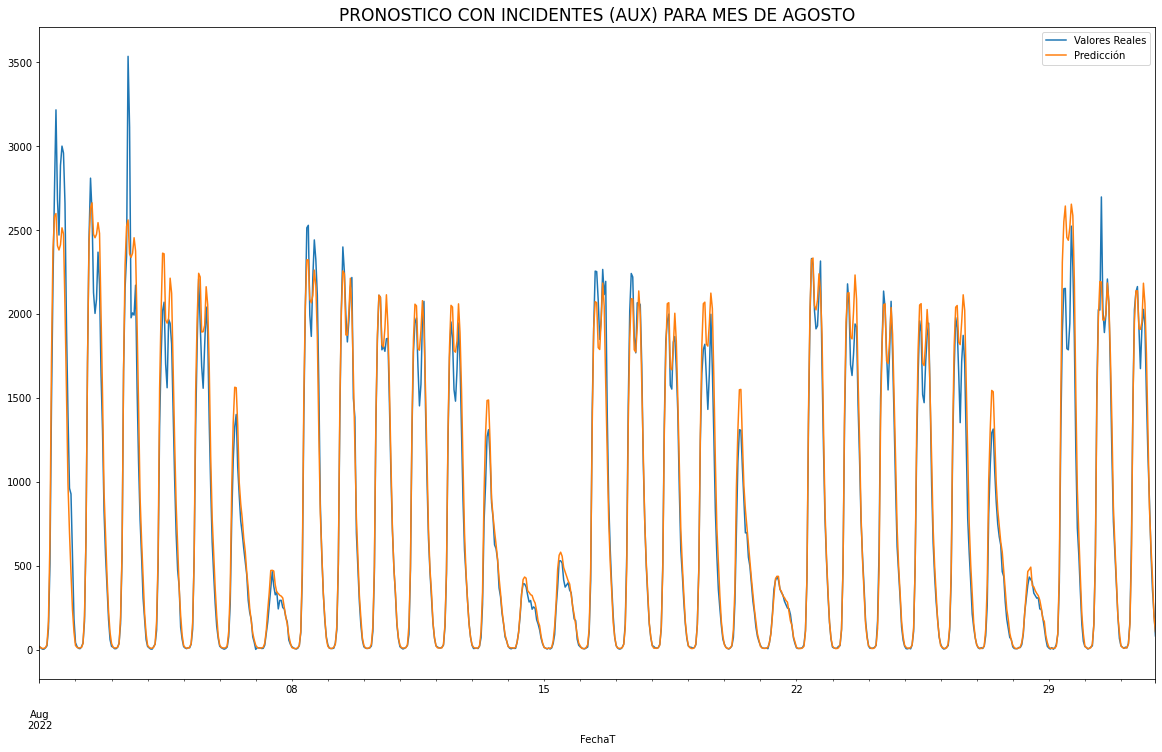

In [49]:
fig, ax = plt.subplots(figsize=(20,12))
y_test.plot(ax=ax, label="Valores Reales")
y_predd.plot(ax=ax, label="RandomForest") #,color = "orange"
plt.title("PRONOSTICO CON INCIDENTES (AUX) PARA MES DE AGOSTO",fontsize = 17)

ax.legend()
fig.show()